# Problem statement:
Build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

In [ ]:
#mounting google drive for easier data integration
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
#unzipping the .zip file
!unzip "/content/gdrive/MyDrive/Upgrad/Skin_cancer_detect.zip"

Archive:  /content/gdrive/MyDrive/Upgrad/Skin_cancer_detect.zip
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0010512.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0010889.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024468.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024470.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024511.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024646.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024654.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024707.jpg  


In [ ]:
#importing ibraries
import pathlib
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import PIL

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

from tensorflow.keras.preprocessing.image import load_img

In [ ]:
# Defining the path for train and test images
data_train = pathlib.Path('/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/')
data_test = pathlib.Path('/content/Skin cancer ISIC The International Skin Imaging Collaboration/Test/')

In [ ]:
# Count the number of image in Train and Test directory
# Using the glob to retrieve files/pathnames matching a specified pattern.

#Train Image count
image_count_train = len(list(data_train.glob('*/*.jpg')))
print(image_count_train)

#Test Image count
image_count_test = len(list(data_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


## Data Visualization

Found 2239 files belonging to 9 classes.


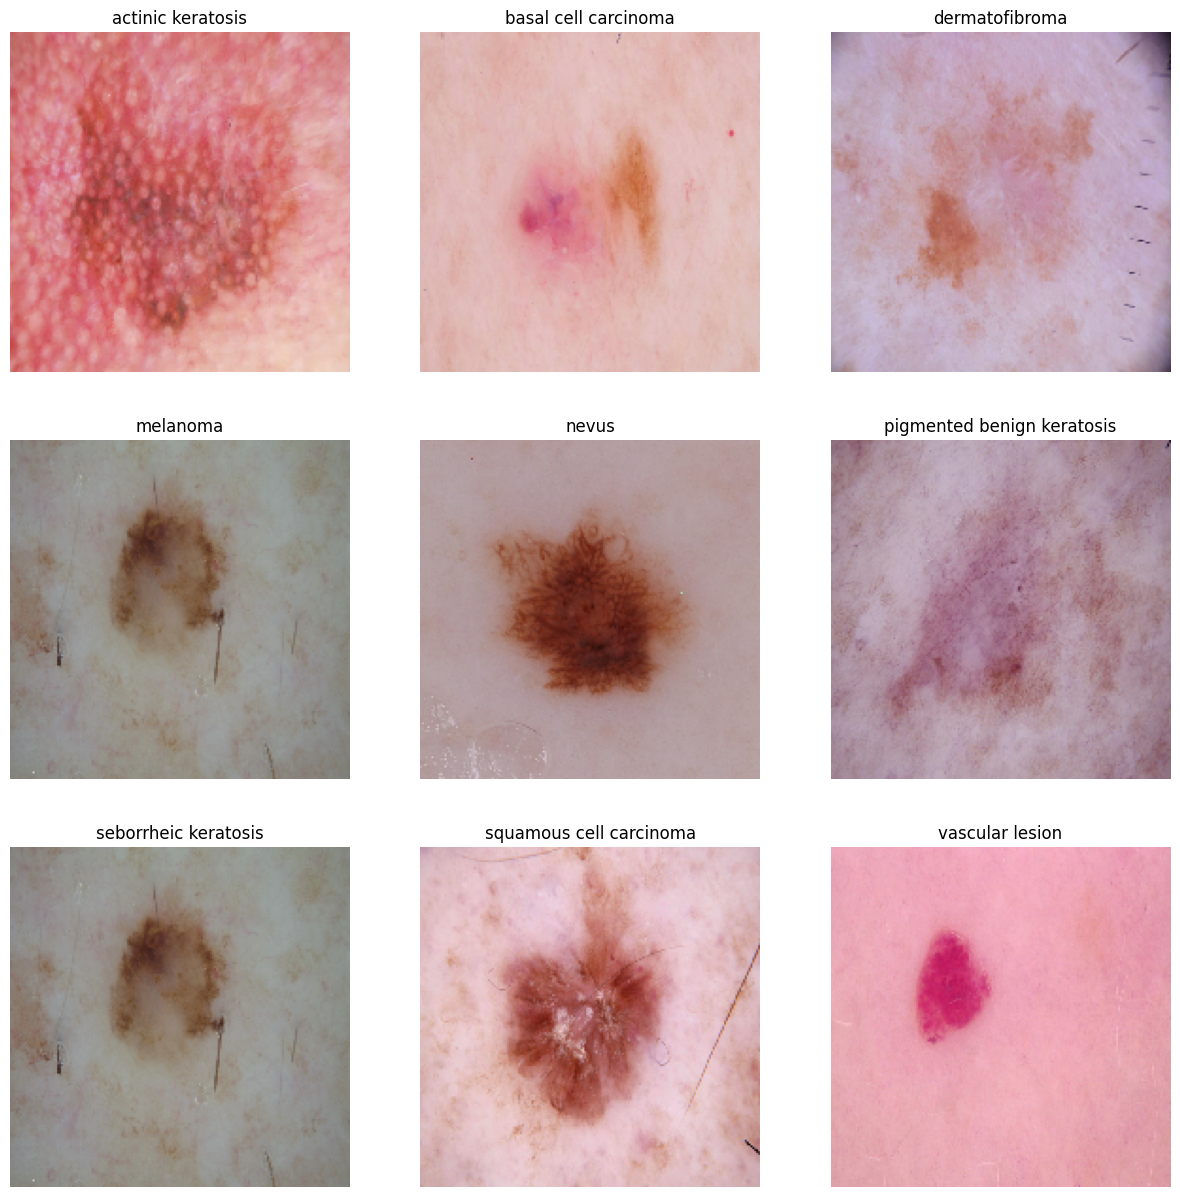

In [ ]:
#Visualize one instance of all the class present in the dataset.

#image_dataset_from_directory() will return a tf.data.Dataset that yields batches of images from the subdirectories.
#label_mode is categorial, the labels are a float32 tensor of shape (batch_size, num_classes), representing a one-hot encoding of the class index.
image_dataset = tf.keras.preprocessing.image_dataset_from_directory(data_train,batch_size=32,image_size=(180,180),
                                                                    label_mode='categorical',seed=123)

#all the classes of Skin Cancer
class_names = image_dataset.class_names

#Dictionary to store the path of image as per the class
files_path_dict = {}

for c in class_names:
    files_path_dict[c] = list(map(lambda x:str(data_train)+'/'+c+'/'+x,os.listdir(str(data_train)+'/'+c)))

#Visualize image
plt.figure(figsize=(15,15))
index = 0
for c in class_names:
    path_list = files_path_dict[c][:1]
    index += 1
    plt.subplot(3,3,index)
    plt.imshow(load_img(path_list[0],target_size=(180,180)))
    plt.title(c)
    plt.axis("off")

## Visualizing the distribution of classes in the training dataset

In [ ]:
def class_distribution_count(directory):

  #counting number of images in each classes
  count=[]
  for path in pathlib.Path(directory).iterdir():
    if path.is_dir():
      count.append(len([name for name in os.listdir(path)
                          if os.path.isfile(os.path.join(path,name))]))

  #naming each class
  sub_directory = [name for name in os.listdir(directory)
                  if os.path.isdir(os.path.join(directory, name))]

  #returning df with image count and class
  return pd.DataFrame(list(zip(sub_directory,count)), columns = ['Class', 'No. of Image'])

df = class_distribution_count(data_train)
df

,Class,No. of Image
0,nevus,357
1,seborrheic keratosis,77
2,pigmented benign keratosis,462
3,dermatofibroma,95
4,vascular lesion,139
5,basal cell carcinoma,376
6,squamous cell carcinoma,181
7,actinic keratosis,114
8,melanoma,438


<Axes: xlabel='No. of Image', ylabel='Class'>

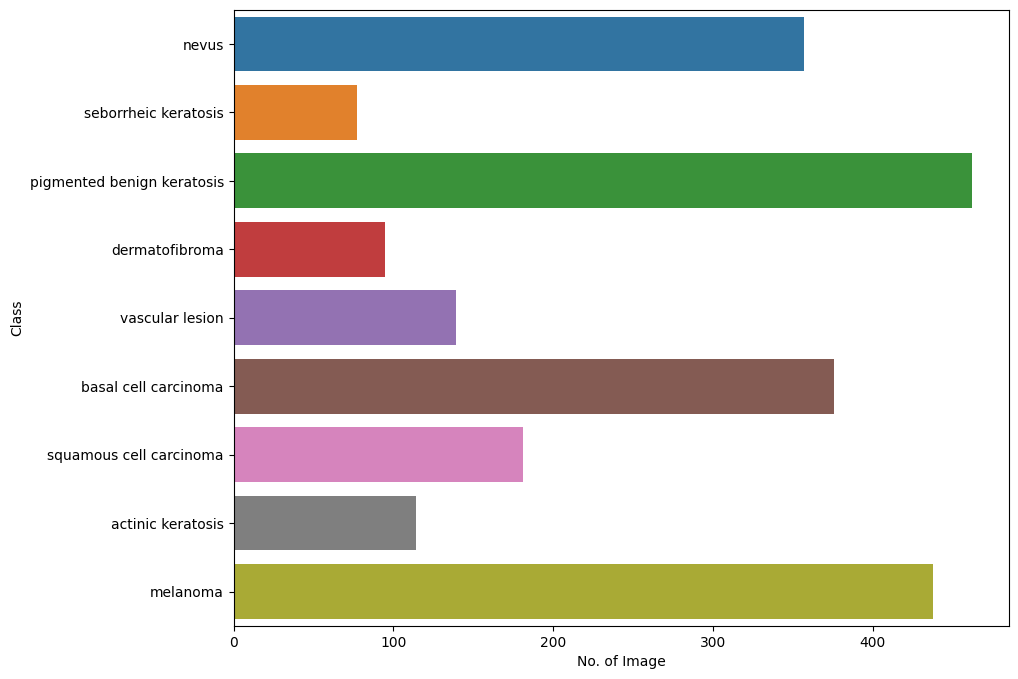

In [ ]:
#Visualize the Number of image in each class.
import seaborn as sns
plt.figure(figsize=(10, 8))
sns.barplot(x="No. of Image", y="Class", data=df,
            label="Class", hue="Class")

In [ ]:
#Count total number of image generated by Augmentor.
image_count_train = len(list(data_train.glob('*/output/*.jpg')))
print(image_count_train)

0


## Creating a dataset
Defining some parameters for the loader

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

Using 80% of images for training, and 20% for validation

## Model Building

In [ ]:
# train dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_train, batch_size=32,
                                                               image_size=(180,180), label_mode='categorical',
                                                               seed=123,subset="training",
                                                               validation_split=0.2)

#label_mode is categorial, the labels are a float32 tensor of shape (batch_size, num_classes),
#representing a one-hot encoding of the class index.

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [ ]:
# validation dataset
val_ds =tf.keras.preprocessing.image_dataset_from_directory(data_train,batch_size=32,
                                                            image_size=(180,180), label_mode='categorical',
                                                            seed=123,subset="validation",
                                                            validation_split=0.2)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


The `image_batch` is tensor of the shape `(32, 180, 180, 3)`. this is a btach of 32 images of shape 180x180x3 (the last dimension refers to color channels RGB). The `label_batch` is tensor of shape `(32,)`, these are correspondinglabels to the 32 images.

`Dataset.casche()` keeps the images in the memory afterr they're loaded off disk during the first epoch.

`Datset.prefetch()` overlaps data preprocessing and model execution while training.

In [ ]:
#tf.data.experimental.AUTOTUNE defines appropriate number of processes that are free for working.

#`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

#`Dataset.prefetch()` overlaps data preprocessing and model execution while training.


AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
#CNN Model Architecture

#Sequential allows you to create models layer-by-layer
model = Sequential()

model.add(layers.Rescaling(1./255,input_shape=(180,180,3)))   #Rescaling Layer

#First Convulation layer
model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Second Convulation Layer
model.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Third Convulation Layer
model.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Dropout layer with 50% Fraction of the input units to drop.
model.add(layers.Dropout(0.5))

#Flatten Layer
##Keras.layers.flatten function flattens the multi-dimensional input tensors into a single dimension.
model.add(layers.Flatten())

#Dense Layer
model.add(layers.Dense(128,activation='relu'))

#Dropout layer with 25% Fraction of the input units to drop.
model.add(layers.Dropout(0.25))

#Dense Layer with softmax activation function.
#Softmax is an activation function that scales numbers/logits into probabilities.
model.add(layers.Dense(len(class_names),activation='softmax'))

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 178, 178, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 87, 87, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 41, 41, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 51200)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       6,553,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,648,137 (25.36 MB)

 Trainable params: 6,648,137 (25.36 MB)

 Non-trainable params: 0 (0.00 B)

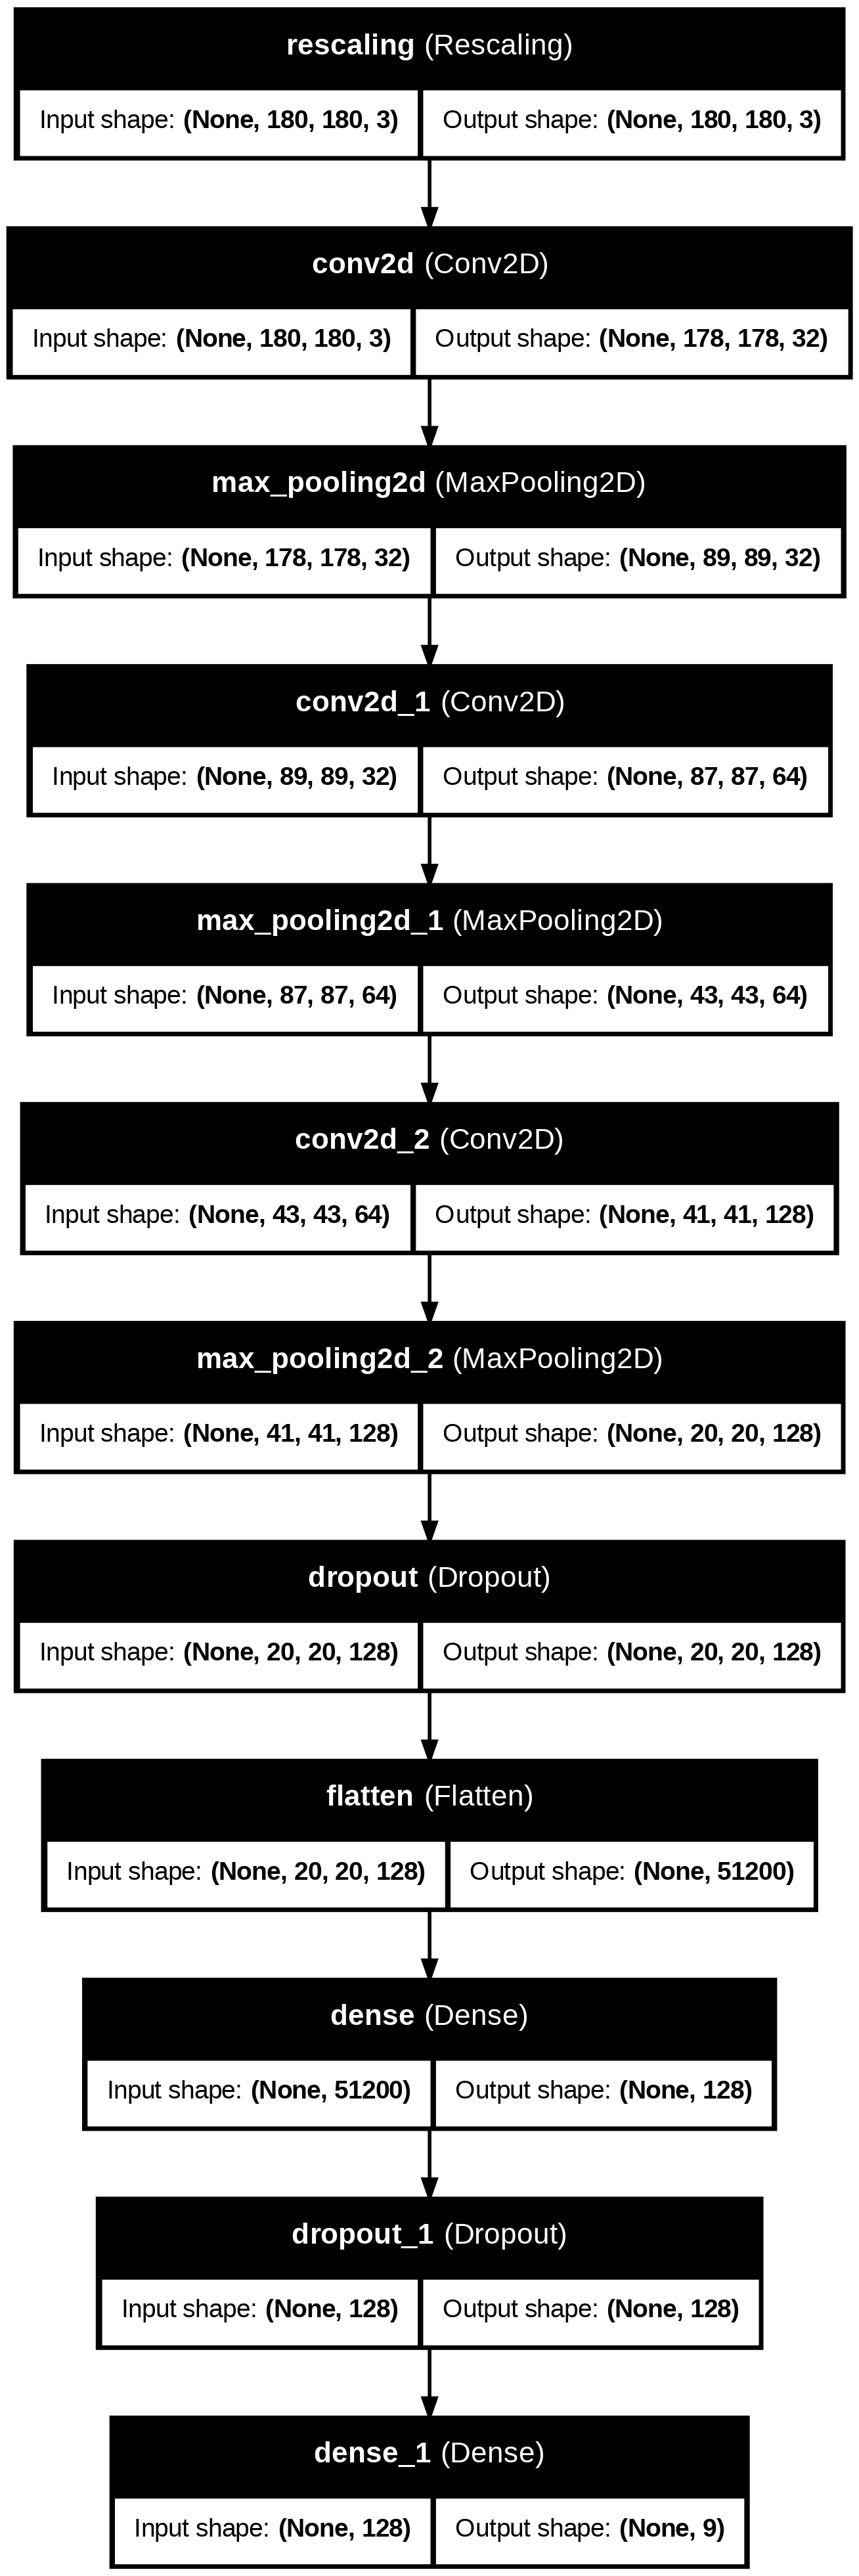

In [ ]:
# vizualizing the model
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
#Compile the Model

#Adam optimization: is a stochastic gradient descent method that is based on adaptive estimation of first-order and second-order moments.
#categorical_crossentropy: Used as a loss function for multi-class classification model where there are two or more output labels.

model.compile(optimizer="Adam",loss="categorical_crossentropy",metrics=["accuracy"])

#ModelCheckpoint callback is used in conjunction with training using model.fit() to save a model or weights (in a checkpoint file) at some interval,
#so the model or weights can be loaded later to continue the training from the state saved.
checkpoint = ModelCheckpoint("model.keras",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)

#Stop training when a monitored metric has stopped improving.
earlystop = EarlyStopping(monitor="val_accuracy",patience=5,mode="auto",verbose=1)

In [20]:
# Train the model
epochs = 20
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs,callbacks=[checkpoint,earlystop])

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7378 - loss: 0.7053
Epoch 1: val_accuracy improved from 0.55928 to 0.56152, saving model to model.keras
56/56 ━━━━━━━━━━━━━━━━━━━━ 133s 2s/step - accuracy: 0.7380 - loss: 0.7049 - val_accuracy: 0.5615 - val_loss: 1.8674
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7344 - loss: 0.7084
Epoch 2: val_accuracy did not improve from 0.56152
56/56 ━━━━━━━━━━━━━━━━━━━━ 120s 2s/step - accuracy: 0.7344 - loss: 0.7086 - val_accuracy: 0.5459 - val_loss: 1.9258
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7577 - loss: 0.6353
Epoch 3: val_accuracy did not improve from 0.56152
56/56 ━━━━━━━━━━━━━━━━━━━━ 141s 2s/step - accuracy: 0.7579 - loss: 0.6351 - val_accuracy: 0.5481 - val_loss: 1.8955
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7905 - loss: 0.5847
Epoch 4: val_accuracy did not improve from 0.56152
56/56 ━━━━━━━━━━━━━━━━━━━━ 142s 2s/step - accuracy: 0.7905 - loss: 0.5848 - val_acc

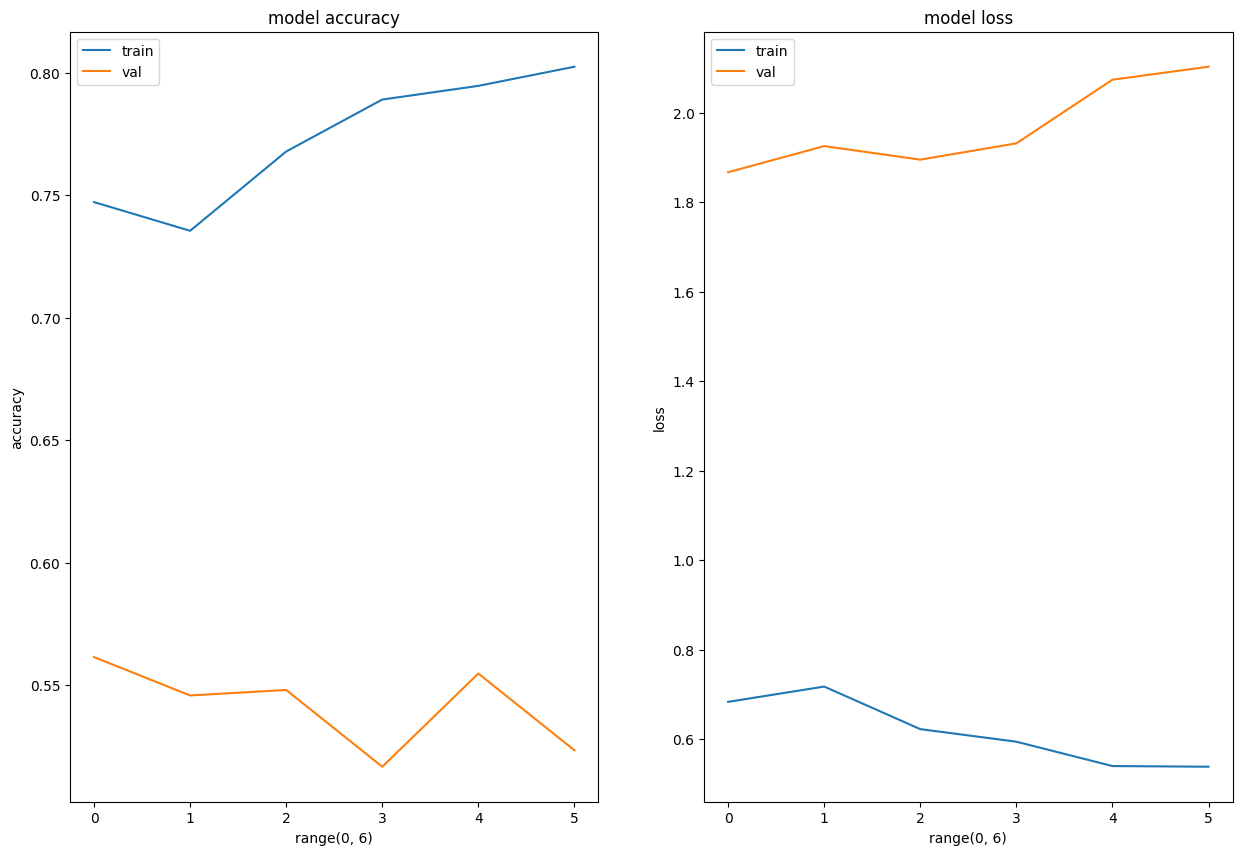

In [21]:
# Plot the training curves

epochs_range = range(earlystop.stopped_epoch+1)

plt.figure(figsize=(15, 10))
plt.subplot(1, 2, 1)

#Plot Model Accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel(epochs_range)
plt.legend(['train', 'val'], loc='upper left')

#Plot Model Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel(epochs_range)
plt.legend(['train', 'val'], loc='upper left')
plt.show()


# Model Prediction - Training dataset (Pre augmentation)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
Actual Class basal cell carcinoma
Predictive Class basal cell carcinoma


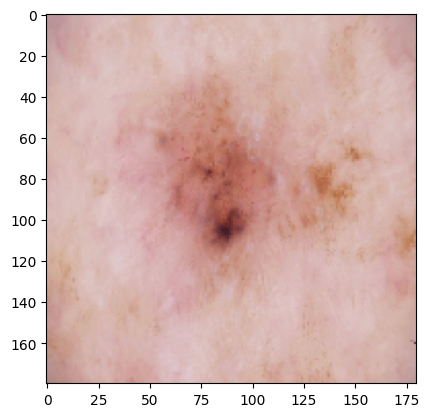

In [38]:
from glob import glob
Train_image_path = os.path.join(data_train, class_names[1], '*')
Train_image = glob(Train_image_path)
Train_image = load_img(Train_image[-1],target_size=(180,180,3))
plt.imshow(Train_image)
plt.grid(False)

img = np.expand_dims(Train_image,axis=0)
pred = model.predict(img)
pred = np.argmax(pred)
pred_class = class_names[pred]
print("Actual Class "+ class_names[1] +'\n'+ "Predictive Class "+pred_class )

# Augmenting Dataste

There is a class imbalance to solve this using a python package  Augmentor (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [23]:
#installing Augmentor
!pip install Augmentor

In [24]:
path_to_training_dataset="/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500)  #Adding 500 samples per class to make sure that none of the classes are sparse

Initialised with 114 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7AF4EAEF6EF0>: 100%|██████████| 500/500 [00:21<00:00, 23.17 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7AF4EAF37EE0>: 100%|██████████| 500/500 [00:20<00:00, 24.00 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7AF4EB0B2200>: 100%|██████████| 500/500 [00:18<00:00, 27.18 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=767x576 at 0x7AF4EAEFFD60>: 100%|██████████| 500/500 [01:22<00:00,  6.03 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=3072x2304 at 0x7AF4EB090AF0>: 100%|██████████| 500/500 [01:21<00:00,  6.11 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7AF4EAED7E80>: 100%|██████████| 500/500 [00:15<00:00, 31.62 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7AF4F94E0910>: 100%|██████████| 500/500 [00:38<00:00, 12.89 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7AF500438EE0>: 100%|██████████| 500/500 [00:15<00:00, 32.08 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7AF500066890>: 100%|██████████| 500/500 [00:15<00:00, 31.82 Samples/s]


# Model Building after Augmenting

## Model Building

In [25]:
# train dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_train, batch_size=32,
                                                               image_size=(180,180), label_mode='categorical',
                                                               seed=123,subset="training",
                                                               validation_split=0.2)

#label_mode is categorial, the labels are a float32 tensor of shape (batch_size, num_classes),
#representing a one-hot encoding of the class index.

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


In [26]:
# validation dataset
val_ds =tf.keras.preprocessing.image_dataset_from_directory(data_train,batch_size=32,
                                                            image_size=(180,180), label_mode='categorical',
                                                            seed=123,subset="validation",
                                                            validation_split=0.2)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


The `image_batch` is tensor of the shape `(32, 180, 180, 3)`. this is a btach of 32 images of shape 180x180x3 (the last dimension refers to color channels RGB). The `label_batch` is tensor of shape `(32,)`, these are correspondinglabels to the 32 images.

`Dataset.casche()` keeps the images in the memory afterr they're loaded off disk during the first epoch.

`Datset.prefetch()` overlaps data preprocessing and model execution while training.

In [27]:
#tf.data.experimental.AUTOTUNE defines appropriate number of processes that are free for working.

#`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

#`Dataset.prefetch()` overlaps data preprocessing and model execution while training.


AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [28]:
#CNN Model Architecture

#Sequential allows you to create models layer-by-layer
model = Sequential()

model.add(layers.Rescaling(1./255,input_shape=(180,180,3)))   #Rescaling Layer

#First Convulation layer
model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Second Convulation Layer
model.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Third Convulation Layer
model.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Dropout layer with 50% Fraction of the input units to drop.
model.add(layers.Dropout(0.5))

#Flatten Layer
##Keras.layers.flatten function flattens the multi-dimensional input tensors into a single dimension.
model.add(layers.Flatten())

#Dense Layer
model.add(layers.Dense(128,activation='relu'))

#Dropout layer with 25% Fraction of the input units to drop.
model.add(layers.Dropout(0.25))

#Dense Layer with softmax activation function.
#Softmax is an activation function that scales numbers/logits into probabilities.
model.add(layers.Dense(len(class_names),activation='softmax'))

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 178, 178, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 87, 87, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 41, 41, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 51200)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │       6,553,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,648,137 (25.36 MB)

 Trainable params: 6,648,137 (25.36 MB)

 Non-trainable params: 0 (0.00 B)

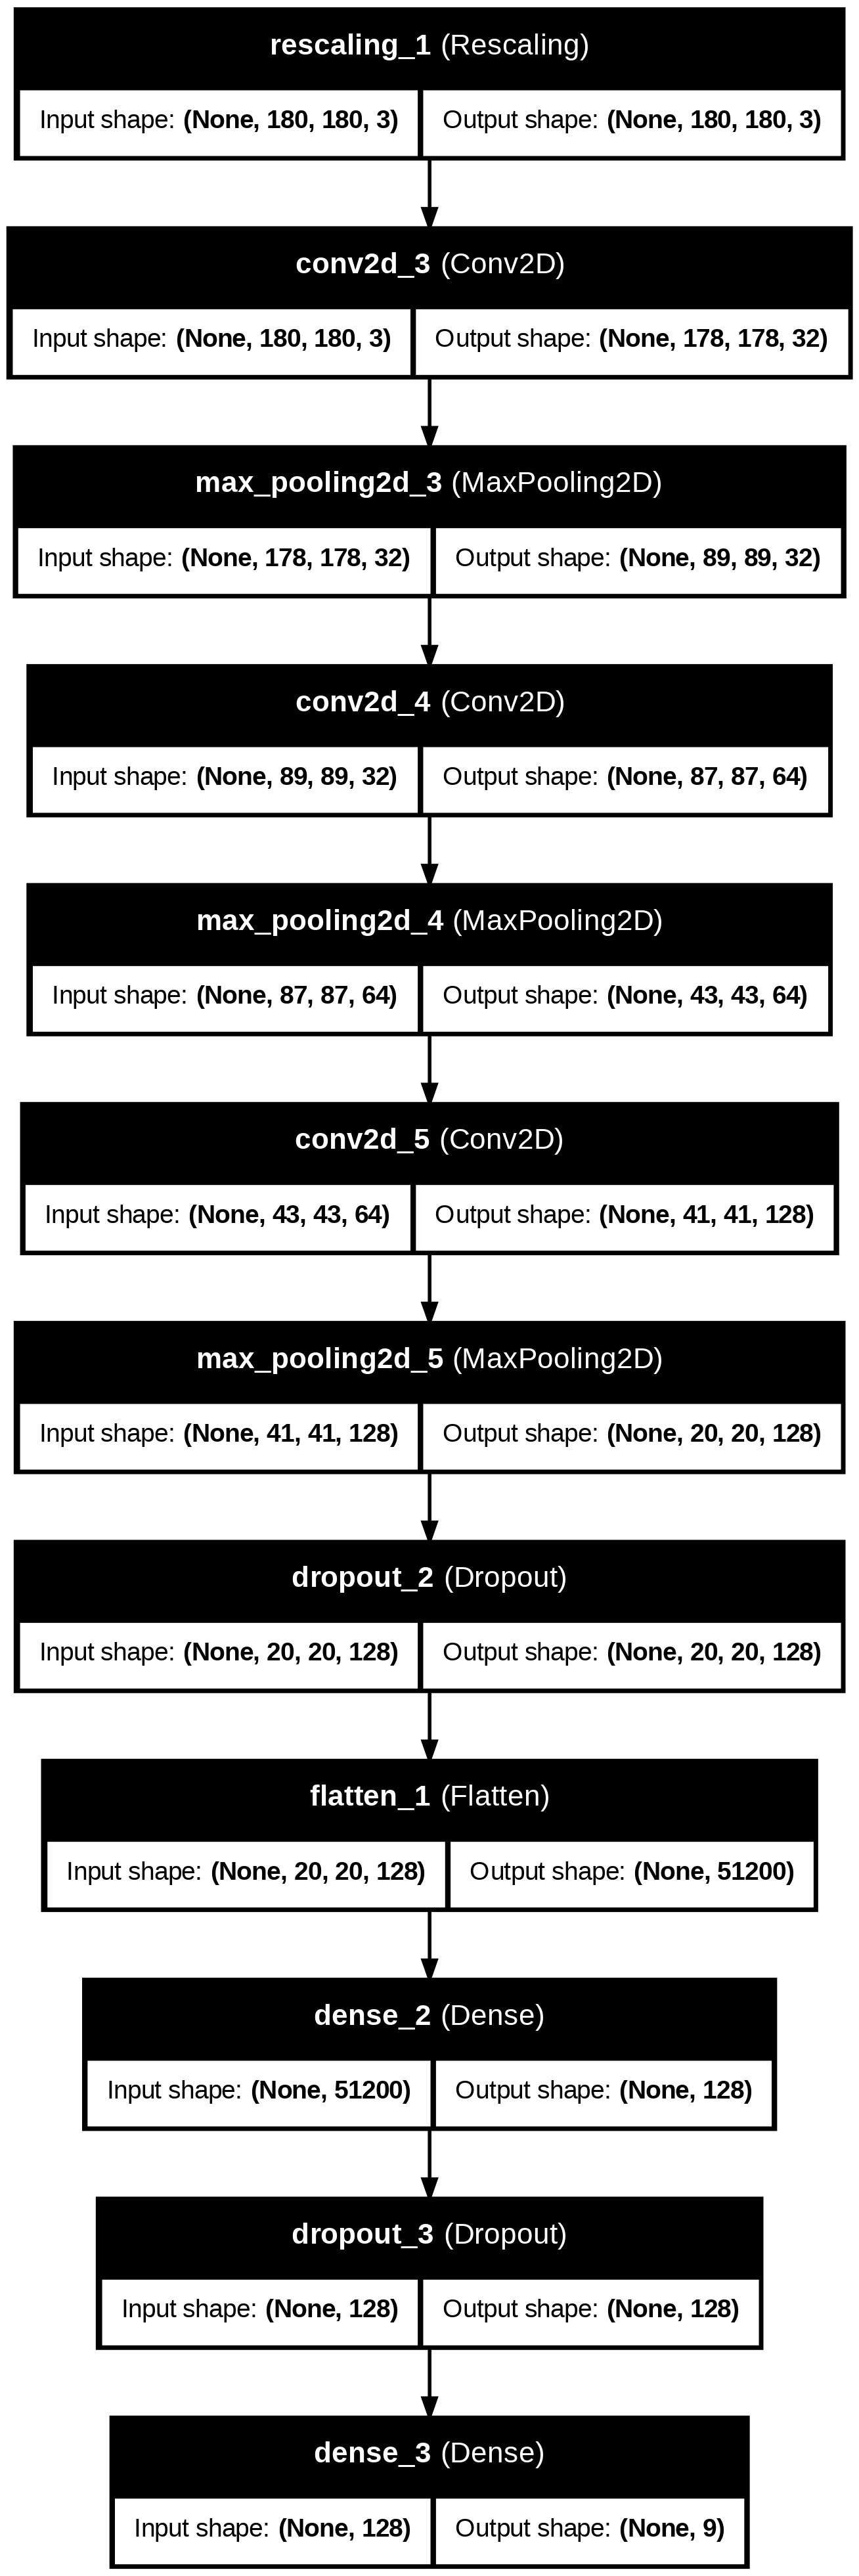

In [29]:
# vizualizing the model
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [30]:
#Compile the Model

#Adam optimization: is a stochastic gradient descent method that is based on adaptive estimation of first-order and second-order moments.
#categorical_crossentropy: Used as a loss function for multi-class classification model where there are two or more output labels.

model.compile(optimizer="Adam",loss="categorical_crossentropy",metrics=["accuracy"])

#ModelCheckpoint callback is used in conjunction with training using model.fit() to save a model or weights (in a checkpoint file) at some interval,
#so the model or weights can be loaded later to continue the training from the state saved.
checkpoint = ModelCheckpoint("model.keras",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)

#Stop training when a monitored metric has stopped improving.
earlystop = EarlyStopping(monitor="val_accuracy",patience=5,mode="auto",verbose=1)

In [31]:
# Train the model
epochs = 20
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs,callbacks=[checkpoint,earlystop])

Epoch 1/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2052 - loss: 2.1538
Epoch 1: val_accuracy improved from -inf to 0.37788, saving model to model.keras
169/169 ━━━━━━━━━━━━━━━━━━━━ 398s 2s/step - accuracy: 0.2056 - loss: 2.1526 - val_accuracy: 0.3779 - val_loss: 1.6012
Epoch 2/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4091 - loss: 1.5559
Epoch 2: val_accuracy improved from 0.37788 to 0.50260, saving model to model.keras
169/169 ━━━━━━━━━━━━━━━━━━━━ 358s 2s/step - accuracy: 0.4092 - loss: 1.5557 - val_accuracy: 0.5026 - val_loss: 1.2961
Epoch 3/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4444 - loss: 1.4446
Epoch 3: val_accuracy did not improve from 0.50260
169/169 ━━━━━━━━━━━━━━━━━━━━ 431s 2s/step - accuracy: 0.4445 - loss: 1.4444 - val_accuracy: 0.4915 - val_loss: 1.2443
Epoch 4/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5167 - loss: 1.2738
Epoch 4: val_accuracy improved from 0.50260 to 0.52635, saving model to model.keras
169/16

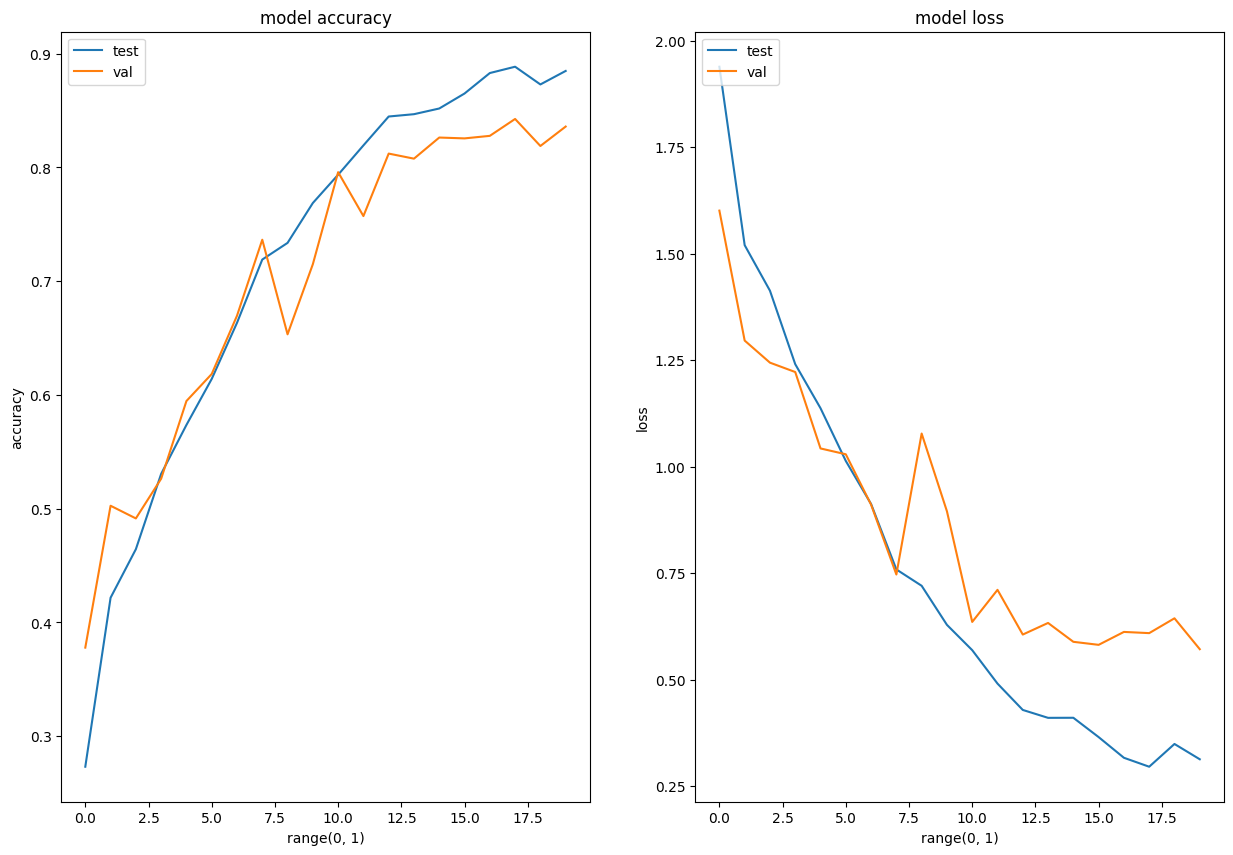

In [50]:
# Plot the training curves

epochs_range = range(earlystop.stopped_epoch+1)

plt.figure(figsize=(15, 10))
plt.subplot(1, 2, 1)

#Plot Model Accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel(epochs_range)
plt.legend(['test', 'val'], loc='upper left')

#Plot Model Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel(epochs_range)
plt.legend(['test', 'val'], loc='upper left')
plt.show()


In [35]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_train, '*','output', '*.jpg'))]
lesion_list_new

['nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',


## Model Prediction - Training dataset (Post augmentation)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Actual Class melanoma
Predictive Class melanoma


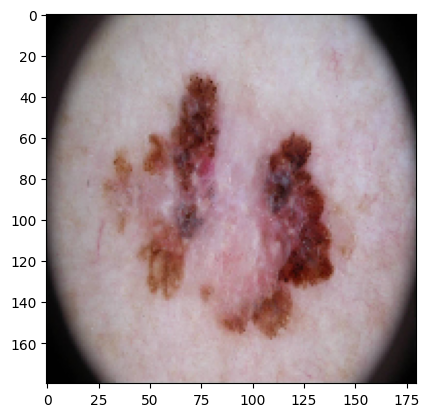

In [98]:
from glob import glob
Test_image_path = os.path.join(data_test, class_names[3], '*')
Test_image = glob(Test_image_path)
Test_image = load_img(Test_image[1],target_size=(180,180,3))
plt.imshow(Test_image)
plt.grid(False)


img = np.expand_dims(Test_image,axis=0)
pred = model.predict(img)
pred = np.argmax(pred)
pred_class = class_names[pred]
print("Actual Class "+ class_names[3] +'\n'+ "Predictive Class "+ pred_class)

# Model Findings
As per latest statistics, Model has formed well on both set training and validation set. It seems that model is almost free from overfitting and underfitting issues. Class rebalance solution is effective for this case.